In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.model_selection import train_test_split , StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
# Load the datasets from pickle files
def load_data(folder_path):
    """Loads all .pkl files from a folder into a list of DataFrames."""
    dataframes = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".pkl"):
            file_path = os.path.join(folder_path, filename)
            try:
                with open(file_path, 'rb') as f:
                    df = pickle.load(f)
                    dataframes.append(df)
                    print(f"Loaded: {filename}")  
            except Exception as e:
                print(f"Error loading {filename}: {e}")
    return dataframes


In [3]:
data_folder = r"C:\Users\ACER\OneDrive\Desktop\Unifiedmentor\fraud_detection\fraud_detection\dataset\data"

In [4]:
dfs = load_data(data_folder)


Loaded: 2018-04-01.pkl
Loaded: 2018-04-02.pkl
Loaded: 2018-04-03.pkl
Loaded: 2018-04-04.pkl
Loaded: 2018-04-05.pkl
Loaded: 2018-04-06.pkl
Loaded: 2018-04-07.pkl
Loaded: 2018-04-08.pkl
Loaded: 2018-04-09.pkl
Loaded: 2018-04-10.pkl
Loaded: 2018-04-11.pkl
Loaded: 2018-04-12.pkl
Loaded: 2018-04-13.pkl
Loaded: 2018-04-14.pkl
Loaded: 2018-04-15.pkl
Loaded: 2018-04-16.pkl
Loaded: 2018-04-17.pkl
Loaded: 2018-04-18.pkl
Loaded: 2018-04-19.pkl
Loaded: 2018-04-20.pkl
Loaded: 2018-04-21.pkl
Loaded: 2018-04-22.pkl
Loaded: 2018-04-23.pkl
Loaded: 2018-04-24.pkl
Loaded: 2018-04-25.pkl
Loaded: 2018-04-26.pkl
Loaded: 2018-04-27.pkl
Loaded: 2018-04-28.pkl
Loaded: 2018-04-29.pkl
Loaded: 2018-04-30.pkl
Loaded: 2018-05-01.pkl
Loaded: 2018-05-02.pkl
Loaded: 2018-05-03.pkl
Loaded: 2018-05-04.pkl
Loaded: 2018-05-05.pkl
Loaded: 2018-05-06.pkl
Loaded: 2018-05-07.pkl
Loaded: 2018-05-08.pkl
Loaded: 2018-05-09.pkl
Loaded: 2018-05-10.pkl
Loaded: 2018-05-11.pkl
Loaded: 2018-05-12.pkl
Loaded: 2018-05-13.pkl
Loaded: 201

In [5]:
if dfs:  # Check if any DataFrames were loaded
    df = pd.concat(dfs, ignore_index=True)
    print("All dataframes concatenated.")
else:
    print("No dataframes loaded. Check the folder path and file types.")
    exit() 

All dataframes concatenated.


In [6]:
print(df.head())


   TRANSACTION_ID         TX_DATETIME CUSTOMER_ID TERMINAL_ID  TX_AMOUNT  \
0               0 2018-04-01 00:00:31         596        3156      57.16   
1               1 2018-04-01 00:02:10        4961        3412      81.51   
2               2 2018-04-01 00:07:56           2        1365     146.00   
3               3 2018-04-01 00:09:29        4128        8737      64.49   
4               4 2018-04-01 00:10:34         927        9906      50.99   

  TX_TIME_SECONDS TX_TIME_DAYS  TX_FRAUD  TX_FRAUD_SCENARIO  
0              31            0         0                  0  
1             130            0         0                  0  
2             476            0         0                  0  
3             569            0         0                  0  
4             634            0         0                  0  


In [7]:

# Convert TX_DATETIME to datetime objects (handle potential errors)
try:
    df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'])
except KeyError:
    print("Error: 'TX_DATETIME' column not found.  Please check your data.")
    exit()
except ValueError as e:
    print(f"Error converting 'TX_DATETIME' to datetime: {e}")
    print("Please ensure the date format is consistent and recognizable.")
    exit()

In [8]:
# Feature Engineering
# 1. Transaction Amount Flag
df['amount_over_220'] = (df['TX_AMOUNT'] > 220).astype(int)

In [9]:
# 2. Time-based Features
df['hour'] = df['TX_DATETIME'].dt.hour
df['day_of_week'] = df['TX_DATETIME'].dt.dayofweek  # Monday=0, Sunday=6
df['month'] = df['TX_DATETIME'].dt.month

# 3. Customer Spending Habits (Example: Average Transaction Amount)
# Calculate customer's average transaction amount
customer_avg = df.groupby('CUSTOMER_ID')['TX_AMOUNT'].mean().reset_index()
customer_avg.rename(columns={'TX_AMOUNT': 'avg_transaction_amount'}, inplace=True)
df = pd.merge(df, customer_avg, on='CUSTOMER_ID', how='left')

# Calculate the ratio of the current transaction amount to the customer's average transaction amount
df['amount_ratio_to_avg'] = df['TX_AMOUNT'] / df['avg_transaction_amount']

In [10]:
# Handle potential division by zero or NaN values:  Important!
df['amount_ratio_to_avg'] = df['amount_ratio_to_avg'].replace([np.inf, -np.inf], np.nan)  # Replace infinite values
df['amount_ratio_to_avg'] = df['amount_ratio_to_avg'].fillna(1)  # Replace NaN with 1 (assuming the transaction amount is equal to the avg)

# 4. Terminal Fraud Count (Example) - You might need more historical data for this in a real application
terminal_fraud_counts = df.groupby('TERMINAL_ID')['TX_FRAUD'].sum().reset_index()
terminal_fraud_counts.rename(columns={'TX_FRAUD': 'terminal_fraud_count'}, inplace=True)
df = pd.merge(df, terminal_fraud_counts, on='TERMINAL_ID', how='left')
df['terminal_fraud_count'] = df['terminal_fraud_count'].fillna(0)

In [11]:
# Select Features
features = ['TX_AMOUNT', 'amount_over_220', 'hour', 'day_of_week', 'avg_transaction_amount', 'amount_ratio_to_avg', 'terminal_fraud_count', 'month']  # Add more engineered features here
target = 'TX_FRAUD'

In [12]:
# Handle missing values
print(f"Missing values before handling:\n{df[features].isnull().sum()}") #Check for missing values BEFORE imputing
df[features] = df[features].fillna(df[features].mean()) # Use mean imputation for numerical features (handle categorical appropriately)
print(f"Missing values after handling:\n{df[features].isnull().sum()}")# Verify if the missing values are handled

Missing values before handling:
TX_AMOUNT                 0
amount_over_220           0
hour                      0
day_of_week               0
avg_transaction_amount    0
amount_ratio_to_avg       0
terminal_fraud_count      0
month                     0
dtype: int64
Missing values after handling:
TX_AMOUNT                 0
amount_over_220           0
hour                      0
day_of_week               0
avg_transaction_amount    0
amount_ratio_to_avg       0
terminal_fraud_count      0
month                     0
dtype: int64


In [13]:
X = df[features]
y = df[target]

In [14]:
# Data Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [15]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42, stratify=y)

In [16]:
print("Data split into training and testing sets.")


Data split into training and testing sets.


In [17]:
# Handle Class Imbalance with SMOTE (Oversampling)
print("Original class distribution:")
print(y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Resampled class distribution (after SMOTE):")
print(y_train_resampled.value_counts())

Original class distribution:
0    1391579
1      11745
Name: TX_FRAUD, dtype: int64
Resampled class distribution (after SMOTE):
1    1391579
0    1391579
Name: TX_FRAUD, dtype: int64


In [18]:
# Model Training (Logistic Regression)
model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced') 

In [19]:
# Cross-validation 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=cv, scoring='roc_auc')
print(f"Cross-validation ROC AUC scores: {cv_scores}")
print(f"Mean cross-validation ROC AUC score: {cv_scores.mean()}")

Cross-validation ROC AUC scores: [0.97774971 0.9778153  0.97778617 0.97808764 0.97784802]
Mean cross-validation ROC AUC score: 0.9778573655351345


In [20]:
# Train the model on the resampled training data
model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

In [21]:
# Model Evaluation
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

In [22]:
print("Model Evaluation:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob)}")

Model Evaluation:
[[337492  10403]
 [   192   2744]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    347895
           1       0.21      0.93      0.34      2936

    accuracy                           0.97    350831
   macro avg       0.60      0.95      0.66    350831
weighted avg       0.99      0.97      0.98    350831

ROC AUC Score: 0.9768368668268907


In [23]:
# Feature Importance (Logistic Regression)
coefficients = model.coef_[0]
feature_importance_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
feature_importance_df['Importance'] = np.abs(feature_importance_df['Coefficient'])
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)


In [24]:
print("\nFeature Importance (Logistic Regression):")
print(feature_importance_df)



Feature Importance (Logistic Regression):
                  Feature  Coefficient  Importance
6    terminal_fraud_count     1.386794    1.386794
5     amount_ratio_to_avg     1.160946    1.160946
1         amount_over_220     0.444798    0.444798
0               TX_AMOUNT    -0.324344    0.324344
4  avg_transaction_amount     0.220212    0.220212
7                   month     0.208015    0.208015
2                    hour     0.020214    0.020214
3             day_of_week    -0.007176    0.007176


In [25]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

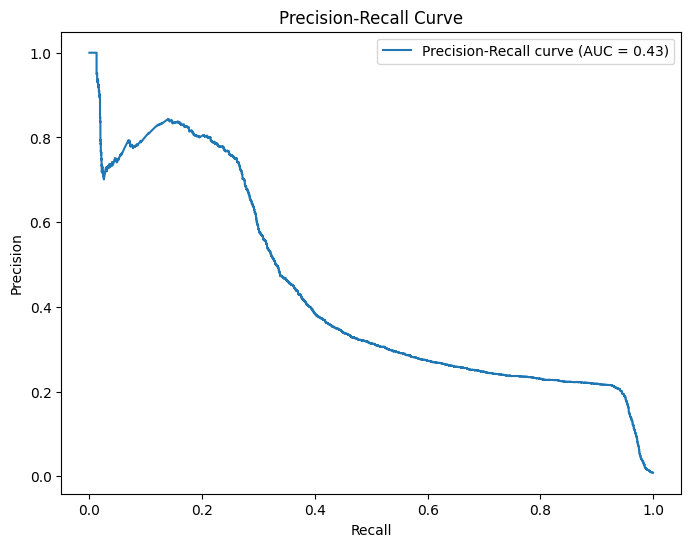

In [26]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [27]:
from sklearn.ensemble import RandomForestClassifier


In [28]:
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train_resampled, y_train_resampled)



RandomForestClassifier(class_weight='balanced', random_state=42)

In [29]:
# Random Forest Feature Importance
rf_feature_importance = rf_model.feature_importances_
rf_feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': rf_feature_importance})
rf_feature_importance_df = rf_feature_importance_df.sort_values('Importance', ascending=False)


In [30]:
print("\nRandom Forest Feature Importance:")
print(rf_feature_importance_df)



Random Forest Feature Importance:
                  Feature  Importance
6    terminal_fraud_count    0.666021
5     amount_ratio_to_avg    0.135693
0               TX_AMOUNT    0.054421
1         amount_over_220    0.044491
7                   month    0.031281
3             day_of_week    0.028028
2                    hour    0.022411
4  avg_transaction_amount    0.017654


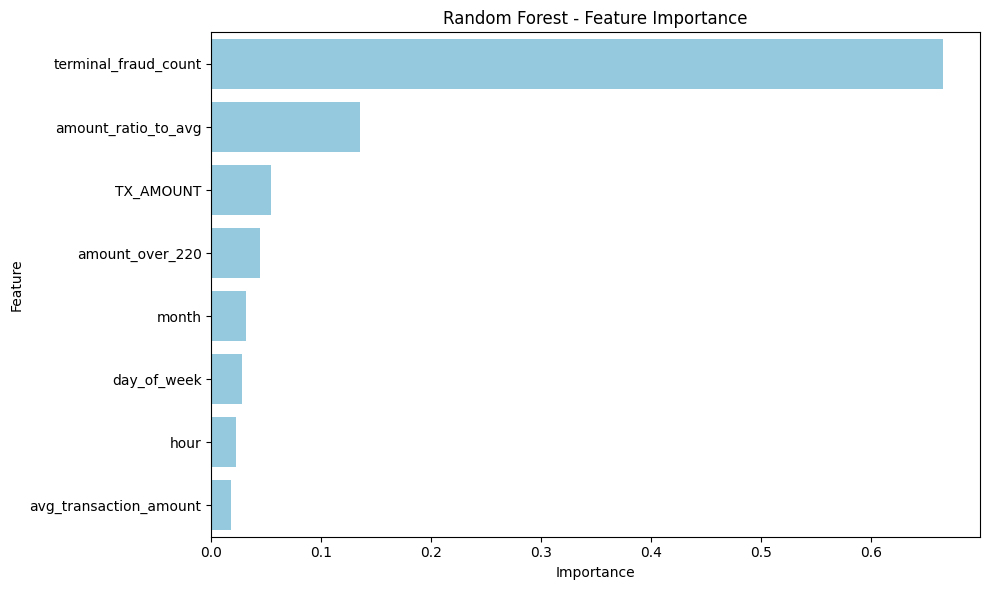

In [33]:
# Plotting Random Forest Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_feature_importance_df, color='skyblue')
plt.title('Random Forest - Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
